In [75]:
%reload_ext autoreload
#%load_ext autoreload
%autoreload 1
%matplotlib inline

import datetime
import pandas as pd
#import modin.pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from tqdm import tqdm


#from sklearnex import patch_sklearn
#patch_sklearn()

from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope, EmpiricalCovariance, MinCovDet
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.cluster import AgglomerativeClustering

from scipy.stats import chi2

import os
import sys
import gc
import joblib

os.chdir("T:\\laupodteam\\AIOS\\Bram\\notebooks\\code_dev\\celldyn_embedder\\sandbox")
#os.chdir("/media/UMCU/notebooks/code_dev/celldyn_embedder/sandbox")
sns.set_style("whitegrid")

write_to_disk = False
read_from_disk = True

from numba import jit, njit, float32
from functools import lru_cache, cached_property
from numpy import linalg as la
from collections import defaultdict
#import ray
#ray.init()

from hembedder.utils.distance import poincarre_dist, fractional_distance, hyperboloid_dist, Distance
from hembedder.prepping import quality
from hembedder.prepping import transformer
from hembedder.prepping import recombinator
from hembedder.prepping import imputer

In [2]:
current_directory = os.path.dirname(os.path.realpath("."))

In [3]:
# function to set all values to their 1st and 99th percentile
def clip_outliers(df, cols, qL=0.01, qH=0.99):
    for col in cols:
        df.loc[:, col] = df[col].clip(df[col].quantile(qL), df[col].quantile(qH))
    return df

# get entropy over a dimension
def get_entropy(data, dim):
    # get the unique values and their counts
    uniq = np.unique(data.loc[:,dim], return_counts=True)
    # get the total number of observations
    total = np.sum(uniq[1])
    # get the probabilities
    probs = uniq[1] / total
    # get the entropy
    entropy = np.sum(probs * np.log2(probs))
    return entropy

In [4]:
#cpath = "T:\laupodteam\AIOS\Bram\data\CellDyn\celldyn_cleaned_transformed_imputed_ALL_with_ratios.feather"
#cpath = "T:\laupodteam\AIOS\Bram\data\CellDyn\celldyn_FULL_transformed_df.feather"
cpath = "T:\laupodteam\AIOS\Bram\data\CellDyn\celldyn_checked.feather"
celldyn = pd.read_feather(cpath)
celldyn.columns = celldyn.columns.str.lower()

celldyn = celldyn.query('c_b_ht>0.2 and c_b_hb>0.2 and c_b_rbco>0.1 and c_b_rbco<100 and c_b_hb<20')
celldyn.drop(['c_b_pblst', 'c_b_pnrbc', 'c_b_pbnd', 
              'c_b_blst', 'c_b_vlym', 'c_b_nrbc', 
              'c_b_bnd', 'c_b_ig',
              'c_b_pig', 'c_b_pvlym'], axis=1, inplace=True, errors='ignore')

meas_cols =[c for c in celldyn.columns if 'c_b_' in c]+['plt']

In [5]:
celldyn['gender']= celldyn.gender.str.decode(encoding='latin1')
celldyn['age'] = celldyn.age.astype(int)
celldyn['meas_hour'] = celldyn['asp_dt'].dt.hour#   apply(lambda x: x.hour)
celldyn['draw_hour'] = celldyn['afname_dt'].dt.hour # .apply(lambda x: x.hour)
celldyn['time_to_measurement'] = (celldyn.asp_dt-celldyn.afname_dt).dt.total_seconds()
celldyn['time_to_measurement'] = celldyn['time_to_measurement']//3600

In [6]:
cond = (celldyn.time_to_measurement<6) & (celldyn.time_to_measurement>-2)
celldyn = celldyn[cond]

In [7]:
meta_cols = ['asp_dt', 'analyzer', 'studyid_alle_celldyn', 
             'time_to_measurement', 'gender', 'age' , 'afname_dt',
             'day_of_year', 'week_of_year', 'year', 'first_day',
              'draw_hour', 'meas_hour']
count_columns = [c for c in celldyn.columns if 'c_cnt' in c]
mode_columns = [c for c in celldyn.columns if 'c_m' in c]
susp_columns = [c for c in celldyn.columns if 'c_s' in c]
alert_columns = [c for c in celldyn.columns if 'alrt' in c]
fail_columns = [c for c in celldyn.columns if 'fail' in c]
all_cols  = meta_cols+meas_cols+mode_columns+susp_columns+alert_columns+count_columns+fail_columns
other_cols = [c for c in celldyn.columns if c not in all_cols]

In [69]:
cleaning = ['qc']
scaling = ['default']
missingness = ['knn']
feature_selection = ['agglomerative']
outlier_method = ['clip', 'isolationforest'] # clip, isolationforest, lof, oneclass_svm, mahalanobis
recombine = True

## Cleaning

In [9]:
entropies = []
for c in meas_cols:
   entropies.append((c, get_entropy(celldyn,c)))

In [10]:
drop_cols = [t[0] for t in entropies if t[1]>-5]
meas_cols = [c for c in meas_cols if c not in drop_cols]
celldyn.drop(drop_cols, axis=1, inplace=True)

In [11]:
if 'qc' in cleaning:
    qc = quality.QcControl(param_file=os.path.join(current_directory, "assets/CelldynParams.xlsx"), 
                        cols_include=meas_cols)

    df = qc.fit_transform(celldyn[meas_cols])
    celldyn[meas_cols] = df

## Scaling

In [12]:
if 'default' in scaling:
    CellDynTransformer = transformer.CellDynTrans(log_scale=[],
                                    ord_scale=[],
                                    remove_original_columns=False)
    df = CellDynTransformer.fit_transform(celldyn[meas_cols])
    celldyn[meas_cols] = df

## Imputing

In [13]:
if 'miceforest' in missingness:
    imputer_clf = imputer.Imputer(imputer='forest',
                        backend='miceforest', 
                        meas_cols = meas_cols,
                        iterations=4, 
                        num_estimators=100, 
                        num_match_candidates=7,
                        save_all_iterations=False,
                        data_subset=0.25,
                        synthesize_working_data=True
                        )
    imputer_clf.fit(celldyn[meas_cols])
    celldyn[meas_cols] = imputer_clf.transform(celldyn[meas_cols])

if 'knn' in missingness:
    imputer_clf = KNNImputer(n_neighbors=10, weights="distance")
    celldyn[meas_cols] = imputer_clf.fit_transform(celldyn[meas_cols])

## Feature selection

In [53]:
# make (BaseEstimator, TransformerMixin) class that extracts clustered features 
# using agglomerative clustering

class AggFeatSel(AgglomerativeClustering):
    def __init__(self, n_clusters=2, metric='euclidean', memory=None, 
                 connectivity=None, compute_full_tree='auto', linkage='ward', 
                 col_names=None):
        
        super().__init__(n_clusters=n_clusters, metric=metric, 
                         memory=memory, connectivity=connectivity, 
                         compute_full_tree=compute_full_tree, 
                         linkage=linkage)
        self.col_names = col_names

    def fit(self, X, y=None):
        super().fit(X)
        return self

    def get_selected_features(self):
        '''
            For each distinct label, arbitrarily select one of the
            columns to represent the cluster
        '''
        _, ui = np.unique(self.labels_, return_index=True)
        
        # TODO: add minimum threshold for similarity

        return list(np.array(self.col_names)[ui])

In [54]:
if 'agglomerative' in feature_selection:
    featSel = AggFeatSel(n_clusters=40, col_names=meas_cols)
    featSel.fit(celldyn[meas_cols].T)
    meas_cols = featSel.get_selected_features()

# Treat outliers

In [57]:
le_pipe = [
        ('scaler', StandardScaler())
]

if 'clip' in outlier_method:
    celldyn = clip_outliers(celldyn, meas_cols, qL=0.01, qH=0.99)

if 'isolationforest' in outlier_method:
    # Isolation forest
    le_pipe.append(('clf', IsolationForest(max_samples=100, random_state=42)))
    pipe = Pipeline(le_pipe, verbose=True)

    pipe.fit(celldyn[meas_cols])
    y_pred_train = pipe.predict(celldyn[meas_cols])
    celldyn['outlier_iso'] = y_pred_train
    meta_cols.append('outlier_iso')
if "lof" in outlier_method:
    # Local outlier factor
    le_pipe.append((LocalOutlierFactor(n_neighbors=20)))
    pipe = Pipeline(le_pipe, verbose=True)

    pipe.fit(celldyn[meas_cols])
    y_pred_train = pipe.predict(celldyn[meas_cols])
    celldyn['outlier_lof'] = y_pred_train
    meta_cols.append('outlier_lof')
if 'oneclass_svm' in outlier_method:
    # One class SVM
    le_pipe.append(('clf', OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)))
    pipe = Pipeline(le_pipe, verbose=True)

    pipe.fit(celldyn[meas_cols])
    y_pred_train = pipe.predict(celldyn[meas_cols])
    celldyn['outlier_svm'] = y_pred_train
    meta_cols.append('outlier_svm')
    
if 'mahalanobis' in outlier_method:
    # robust mahalanobis distance
    pipe = Pipeline(le_pipe, verbose=True)
    pipe.fit(celldyn[meas_cols])
    new_data = pipe.transform(celldyn[meas_cols])
    clf_cov = MinCovDet(random_state=0).fit(new_data)
    mahal_dist = clf_cov.mahalanobis(new_data)

    # add probability by comparing mahalanobis distance to chi2 distribution
    celldyn['mahal_dist'] = mahal_dist
    celldyn['mahal_prob'] = 1 - chi2.cdf(mahal_dist, 2)
    meta_cols.extend(['mahal_dist', 'mahal_prob'])


[Pipeline] ............ (step 1 of 2) Processing scaler, total=   1.9s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   3.6s


# Recombinator

In [88]:
if recombine:
    recombiner = recombinator.CellDynRecombinator(scaler=None, base_combos=True)
    recombiner.fit(celldyn[meas_cols])
    celldyn_combo = pd.DataFrame(data=recombiner.transform(celldyn[meas_cols]),
                                 columns=recombiner.out_columns,
                                 index=celldyn.index)
    

AttributeError: 'DataFrame' object has no attribute 'c_b_neu'

## Seasonal variation

<AxesSubplot:xlabel='week_of_year', ylabel='age'>

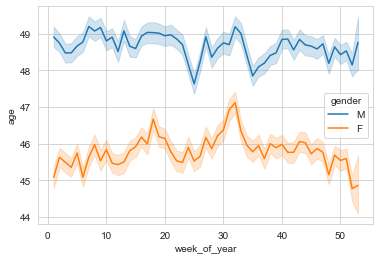

In [6]:
sns.lineplot(data=celldyn.loc[celldyn.gender.isin(['M', 'F'])], x='week_of_year', y='age', hue='gender')

In [7]:
celldyn = celldyn.assign(abs_week = lambda x: x['week_of_year'] + 52*(x['year']-x['year'].min()))

C:\Users\bes3\AppData\Local\Temp/ipykernel_26148/2148000156.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=plot_df, x='week_of_year', y=var, palette='Set2', ax=ax, legend=False)


Text(0.5, 1.0, 'Median of neu:seg by week of year')

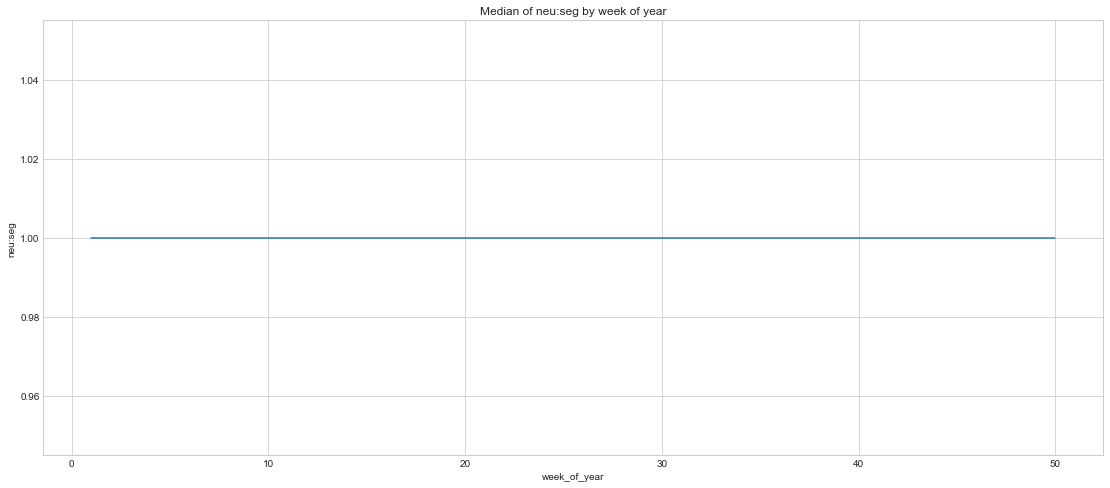

In [58]:
var = 'neu:seg'
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(19, 8))
plot_df = celldyn.query('abs_week<700 & week_of_year<51')\
                .groupby(['week_of_year'])\
                .agg({var: 'median'}).reset_index()
sns.lineplot(data=plot_df, x='week_of_year', y=var, palette='Set2', ax=ax, legend=False)
ax.set_title(f'Median of {var} by week of year')
#ax.set_xlim(0, 700)
#ax.set_ylim(0.55, 0.65)

### Patients who have measurements in the evening and during the day

In [8]:
meas_per_patient = celldyn.shape[0]/celldyn.studyid_alle_celldyn.nunique()
print(f"There are on average {meas_per_patient} measurements per patient")

There are on average 8.627080928240392 measurements per patient


In [9]:
counts_per_patient = pd.DataFrame(celldyn.groupby('studyid_alle_celldyn').size(),  
                        columns=['counts_per_patient'])
celldyn = celldyn.merge(counts_per_patient.reset_index(), how='left', on='studyid_alle_celldyn')

In [10]:
meta_cols = ['asp_dt', 'analyzer', 'studyid_alle_celldyn', 
             'time_to_measurement', 'gender', 'age' , 'afname_dt',
             'day_of_year', 'week_of_year', 'year', 'first_day',
              'draw_hour', 'meas_hour', 'draw_minute', 'draw_hour_dec']

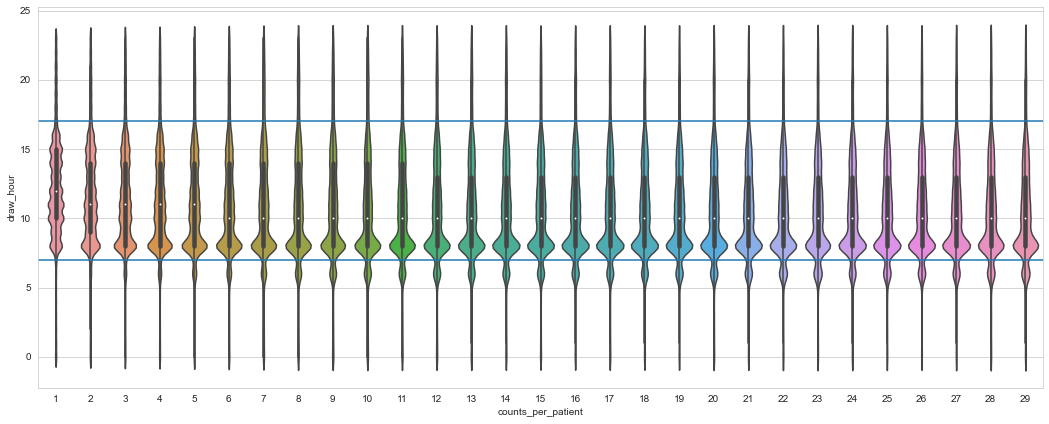

In [11]:
fig, ax = plt.subplots(figsize=(18,7))
sns.violinplot(data=celldyn[celldyn.counts_per_patient<30], x='counts_per_patient', y='draw_hour')
plt.axhline(7)
plt.axhline(17)

There are three blocks: 
* routine block: from 7AM to 5PM, mostly poli perhaps?
* evening block: from 5PM to 12PM
* morning block: from 12PM to 7AM

In [12]:
celldyn.loc[:,'care_block'] = celldyn.apply(lambda x: 'routine_block'\
                                    if (x['draw_hour']>=7) & (x['draw_hour']<17)
                                    else 'evening_block' if (x['draw_hour']>=17) & (x['draw_hour']<=23)
                                    else 'morning_block', axis=1
)
meta_cols.append('care_block')
celldyn = celldyn.assign(draw_minute=celldyn.afname_dt.dt.minute)

In [13]:
celldyn = celldyn.assign(draw_hour_dec=celldyn[['draw_hour', 'draw_minute']].apply(lambda x: round(x[0]+x[1]/60, 1), axis=1))


Text(0.5, 0.98, 'Hourly variation in granulocytes')

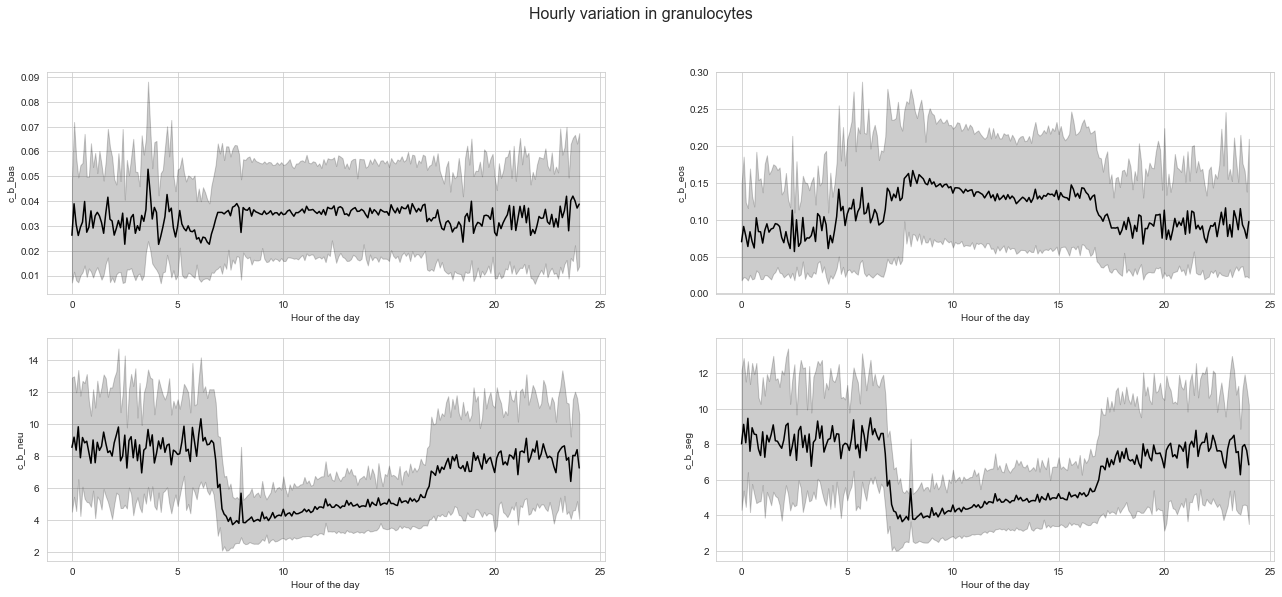

In [15]:
plot_df = celldyn.sample(250000)
plot_df = plot_df.groupby('draw_hour_dec').c_b_bas.quantile([0.25, 0.5, 0.75]).to_frame().join(
          plot_df.groupby('draw_hour_dec').c_b_eos.quantile([0.25, 0.5, 0.75]).to_frame()).join(
          plot_df.groupby('draw_hour_dec').c_b_neu.quantile([0.25, 0.5, 0.75]).to_frame()).join(
          plot_df.groupby('draw_hour_dec').c_b_seg.quantile([0.25, 0.5, 0.75]).to_frame()).reset_index()

plot_df.rename(columns={'level_1': 'percentile'}, inplace=True)

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(22,9))

sns.lineplot(data=plot_df, x='draw_hour_dec', y='c_b_bas', color='black', ax=ax[0,0])
sns.lineplot(data=plot_df, x='draw_hour_dec', y='c_b_eos', color='black', ax=ax[0,1])
sns.lineplot(data=plot_df, x='draw_hour_dec', y='c_b_neu', color='black', ax=ax[1,0])
sns.lineplot(data=plot_df, x='draw_hour_dec', y='c_b_seg', color='black', ax=ax[1,1])

ax[0,0].set_xlabel('Hour of the day')
ax[0,1].set_xlabel('Hour of the day')
ax[1,0].set_xlabel('Hour of the day')
ax[1,1].set_xlabel('Hour of the day')

plt.suptitle('Hourly variation in granulocytes', fontsize=16)

Text(0.5, 0.98, 'Hourly variation in agranulocytes')

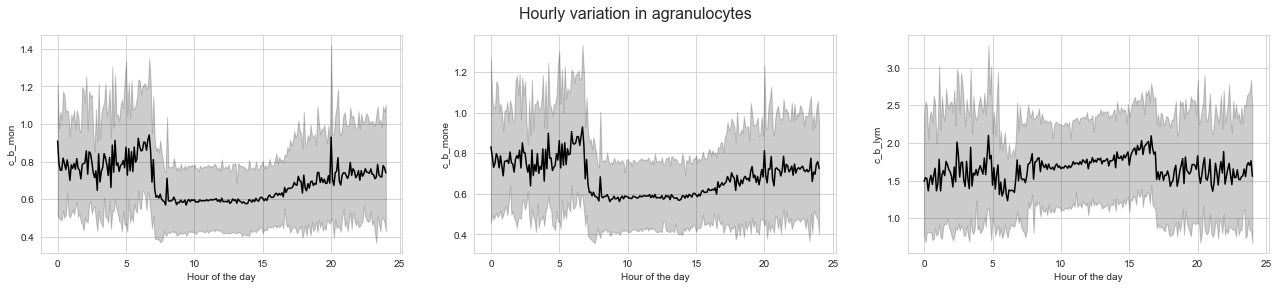

In [16]:
plot_df = celldyn.sample(250000)
plot_df = plot_df.groupby('draw_hour_dec').c_b_mon.quantile([0.25, 0.5, 0.75]).to_frame().join(
          plot_df.groupby('draw_hour_dec').c_b_mone.quantile([0.25, 0.5, 0.75]).to_frame()).join(
          plot_df.groupby('draw_hour_dec').c_b_lym.quantile([0.25, 0.5, 0.75]).to_frame()).reset_index()
plot_df.rename(columns={'level_1': 'percentile'}, inplace=True)

fig, ax = plt.subplots(ncols=3, figsize=(22,4))
sns.lineplot(data=plot_df, x='draw_hour_dec', y='c_b_mon', color='black', ax=ax[0])
sns.lineplot(data=plot_df, x='draw_hour_dec', y='c_b_mone', color='black', ax=ax[1])
sns.lineplot(data=plot_df, x='draw_hour_dec', y='c_b_lym', color='black', ax=ax[2])
# seg
ax[0].set_xlabel('Hour of the day')
ax[1].set_xlabel('Hour of the day')
ax[2].set_xlabel('Hour of the day')

plt.suptitle('Hourly variation in agranulocytes', fontsize=16)

Text(0.5, 0.98, 'Hourly variation in red/white blood cells ')

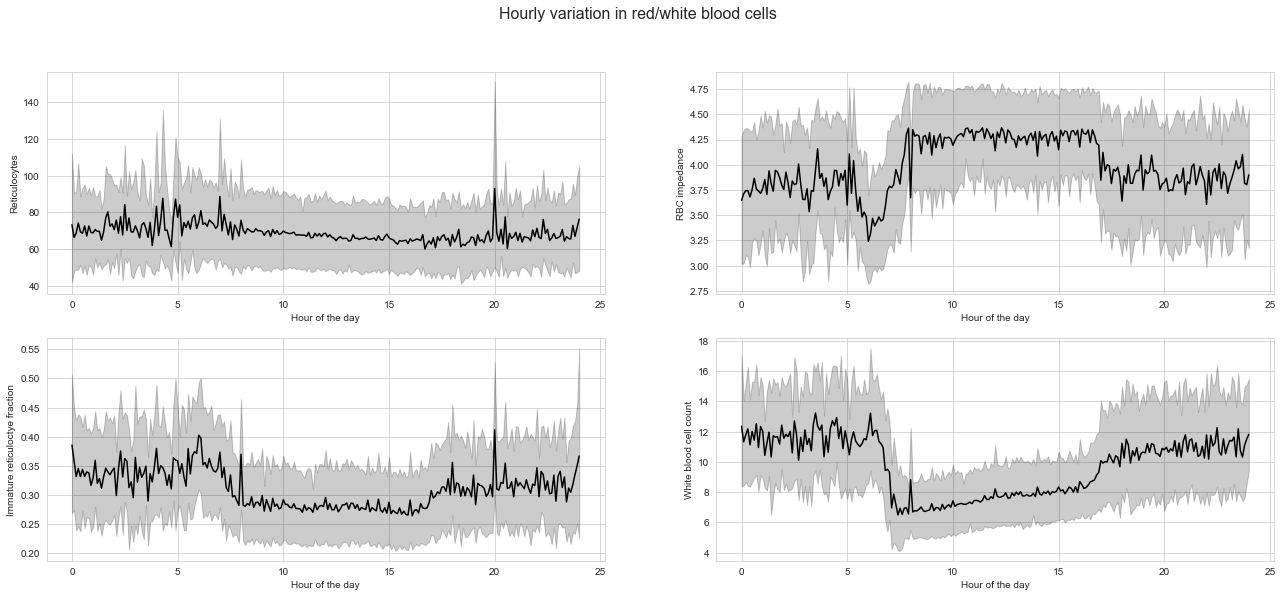

In [17]:
plot_df = celldyn.sample(250000)
plot_df = plot_df.groupby('draw_hour_dec').c_b_retc.quantile([0.25, 0.5, 0.75]).to_frame().join(
          plot_df.groupby('draw_hour_dec').c_b_rbci.quantile([0.25, 0.5, 0.75]).to_frame()).join(
          plot_df.groupby('draw_hour_dec').c_b_irf.quantile([0.25, 0.5, 0.75]).to_frame()).join(
          plot_df.groupby('draw_hour_dec').c_b_wbc.quantile([0.25, 0.5, 0.75]).to_frame()).reset_index()

plot_df.rename(columns={'level_1': 'percentile'}, inplace=True)
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(22,9))

sns.lineplot(data=plot_df, x='draw_hour_dec', y='c_b_retc', color='black', ax=ax[0,0])
sns.lineplot(data=plot_df, x='draw_hour_dec', y='c_b_rbci', color='black', ax=ax[0,1])
sns.lineplot(data=plot_df, x='draw_hour_dec', y='c_b_irf', color='black', ax=ax[1,0])
sns.lineplot(data=plot_df, x='draw_hour_dec', y='c_b_wbc', color='black', ax=ax[1,1])

ax[0,0].set_xlabel('Hour of the day')
ax[0,1].set_xlabel('Hour of the day')
ax[1,0].set_xlabel('Hour of the day')
ax[1,1].set_xlabel('Hour of the day')

ax[0,0].set_ylabel('Reticulocytes')
ax[0,1].set_ylabel('RBC impedance')
ax[1,0].set_ylabel('Immature reticuloctye fraction')
ax[1,1].set_ylabel('White blood cell count')

plt.suptitle('Hourly variation in red/white blood cells ', fontsize=16)

Text(0.5, 0.98, 'Hourly variation in platelets ')

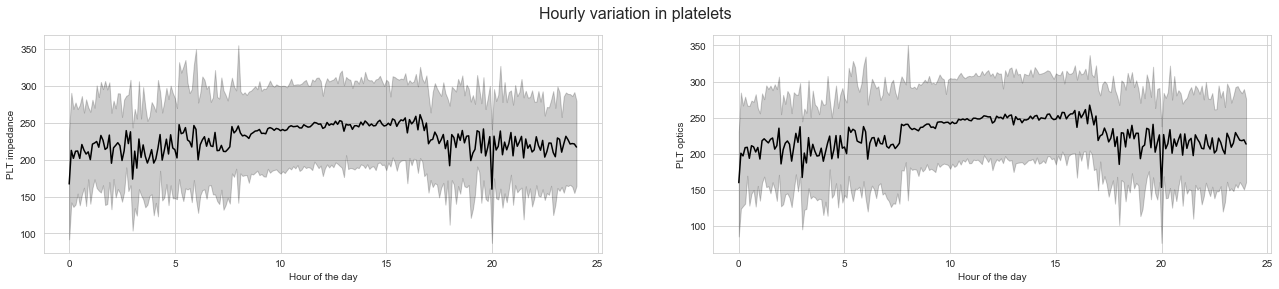

In [18]:
plot_df = celldyn.sample(250000)
plot_df = plot_df.groupby('draw_hour_dec').c_b_plti.quantile([0.25, 0.5, 0.75]).to_frame().join(
          plot_df.groupby('draw_hour_dec').c_b_plto.quantile([0.25, 0.5, 0.75]).to_frame()).reset_index()

fig, ax = plt.subplots(ncols=2, figsize=(22,4))

sns.lineplot(data=plot_df, x='draw_hour_dec', y='c_b_plti', color='black', ax=ax[0])
sns.lineplot(data=plot_df, x='draw_hour_dec', y='c_b_plto', color='black', ax=ax[1])

ax[0].set_xlabel('Hour of the day')
ax[1].set_xlabel('Hour of the day')

ax[0].set_ylabel('PLT impedance')
ax[1].set_ylabel('PLT optics')

plt.suptitle('Hourly variation in platelets ', fontsize=16)

Text(0.5, 0.98, 'Hourly variation of aggregate blood parameters ')

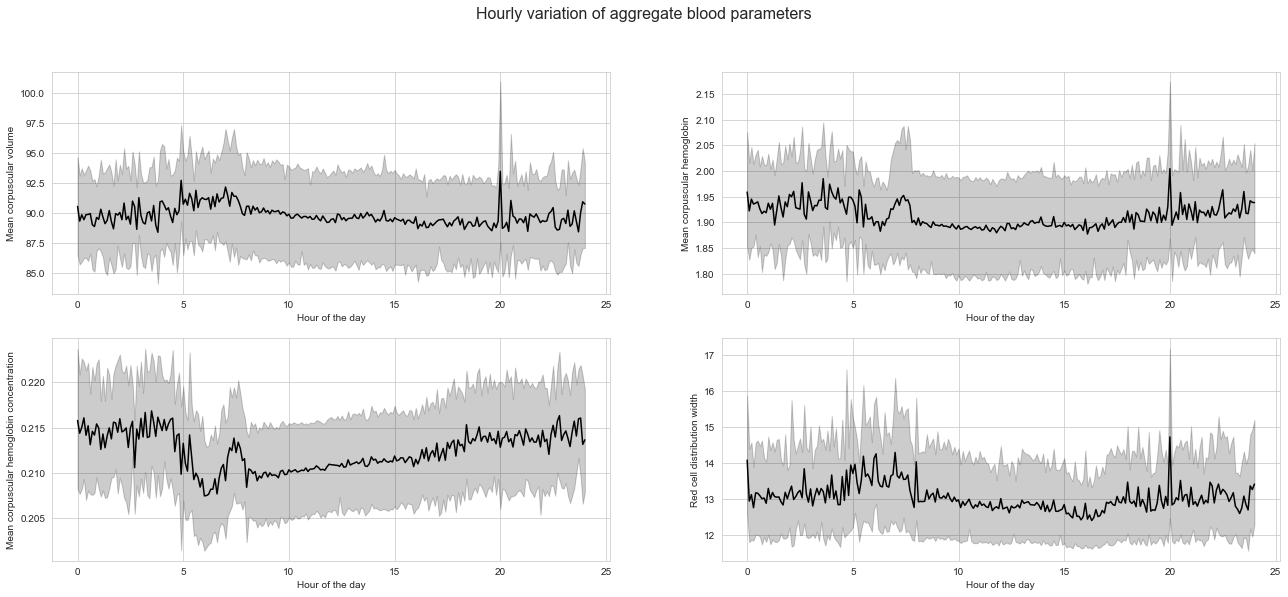

In [19]:
plot_df = celldyn.sample(250000)
plot_df = plot_df.groupby('draw_hour_dec').c_b_mcv.quantile([0.25, 0.5, 0.75]).to_frame().join(
          plot_df.groupby('draw_hour_dec').c_b_mch.quantile([0.25, 0.5, 0.75]).to_frame()).join(
          plot_df.groupby('draw_hour_dec').c_b_mchc.quantile([0.25, 0.5, 0.75]).to_frame()).join(
          plot_df.groupby('draw_hour_dec').c_b_rdw.quantile([0.25, 0.5, 0.75]).to_frame()).reset_index()
          
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(22,9))

sns.lineplot(data=plot_df, x='draw_hour_dec', y='c_b_mcv', color='black', ax=ax[0,0])
sns.lineplot(data=plot_df, x='draw_hour_dec', y='c_b_mch', color='black', ax=ax[0,1])
sns.lineplot(data=plot_df, x='draw_hour_dec', y='c_b_mchc', color='black', ax=ax[1,0])
sns.lineplot(data=plot_df, x='draw_hour_dec', y='c_b_rdw', color='black', ax=ax[1,1])


ax[0,0].set_xlabel('Hour of the day')
ax[0,1].set_xlabel('Hour of the day')
ax[1,0].set_xlabel('Hour of the day')
ax[1,1].set_xlabel('Hour of the day')

ax[0,0].set_ylabel('Mean corpuscular volume')
ax[0,1].set_ylabel('Mean corpuscular hemoglobin')
ax[1,0].set_ylabel('Mean corpuscular hemoglobin concentration')
ax[1,1].set_ylabel('Red cell distribution width')

plt.suptitle('Hourly variation of aggregate blood parameters ', fontsize=16)

Text(0.5, 0.98, 'Hourly variation in platelets ')

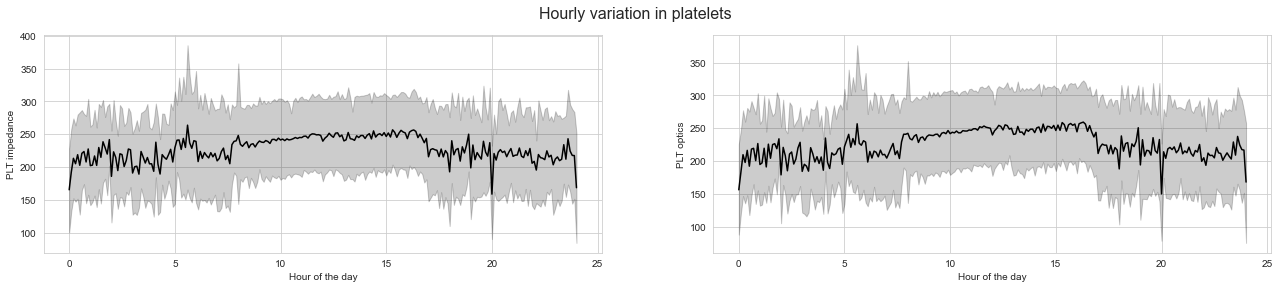

In [20]:
plot_df = celldyn.sample(250000)
plot_df = plot_df.groupby('draw_hour_dec').c_b_plti.quantile([0.25, 0.5, 0.75]).to_frame().join(
          plot_df.groupby('draw_hour_dec').c_b_plto.quantile([0.25, 0.5, 0.75]).to_frame()).reset_index()

fig, ax = plt.subplots(ncols=2, figsize=(22,4))

sns.lineplot(data=plot_df, x='draw_hour_dec', y='c_b_plti', color='black', ax=ax[0])
sns.lineplot(data=plot_df, x='draw_hour_dec', y='c_b_plto', color='black', ax=ax[1])

ax[0].set_xlabel('Hour of the day')
ax[1].set_xlabel('Hour of the day')

ax[0].set_ylabel('PLT impedance')
ax[1].set_ylabel('PLT optics')

plt.suptitle('Hourly variation in platelets ', fontsize=16)

In [21]:
# wbc/(retc+irf), neu/seg, lym/mon, wbc/plti, plti/(retc+irf), wbc/(mon+lym), ig/(bas+neu+eos), retc/hb, wbc/rbci, rbci/(retc+irf)

celldyn = celldyn.assign(wbc_over_rbc=0.5*celldyn.c_b_wbc/(celldyn.c_b_rbci+celldyn.c_b_rbco))
celldyn = celldyn.assign(neu_over_seg=celldyn.c_b_neu/celldyn.c_b_seg)
celldyn = celldyn.assign(neu_over_wbc=celldyn.c_b_neu/(celldyn.c_b_wbc-celldyn.c_b_neu))
celldyn = celldyn.assign(lym_over_mon=celldyn.c_b_lym/celldyn.c_b_mon)
celldyn = celldyn.assign(wbc_over_plt=celldyn.c_b_wbc/celldyn.plt) # plti, plto
celldyn = celldyn.assign(plt_over_rbc=0.5*celldyn.plt/(celldyn.c_b_rbci+celldyn.c_b_rbco))
celldyn = celldyn.assign(retc_over_hb=celldyn.c_b_retc/celldyn.c_b_hb)
celldyn = celldyn.assign(rbc_over_irbc=celldyn.c_b_rbci/(celldyn.c_b_retc+celldyn.c_b_irf))
celldyn = celldyn.assign(plt_over_lym=celldyn.plt/celldyn.c_b_lym)

Text(0.5, 0.98, 'Hourly variation of hematology ratios ')

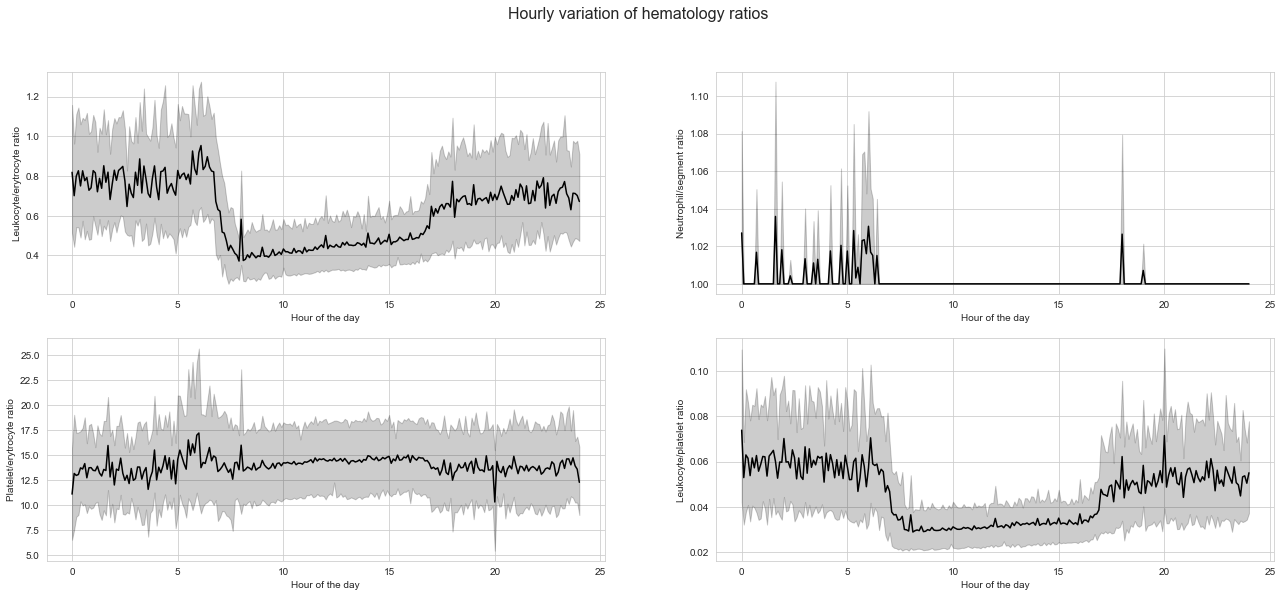

In [22]:
# wbc_over_rbc
# neu_over_seg
# plt_over_rbc
# wbc_over_plt

plot_df = celldyn.sample(250000)
plot_df = plot_df.groupby('draw_hour_dec').wbc_over_rbc.quantile([0.25, 0.5, 0.75]).to_frame().join(
          plot_df.groupby('draw_hour_dec').neu_over_seg.quantile([0.25, 0.5, 0.75]).to_frame()).join(
          plot_df.groupby('draw_hour_dec').plt_over_rbc.quantile([0.25, 0.5, 0.75]).to_frame()).join(
          plot_df.groupby('draw_hour_dec').wbc_over_plt.quantile([0.25, 0.5, 0.75]).to_frame()).reset_index()
          
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(22,9))

sns.lineplot(data=plot_df, x='draw_hour_dec', y='wbc_over_rbc', color='black', ax=ax[0,0])
sns.lineplot(data=plot_df, x='draw_hour_dec', y='neu_over_seg', color='black', ax=ax[0,1])
sns.lineplot(data=plot_df, x='draw_hour_dec', y='plt_over_rbc', color='black', ax=ax[1,0])
sns.lineplot(data=plot_df, x='draw_hour_dec', y='wbc_over_plt', color='black', ax=ax[1,1])


ax[0,0].set_xlabel('Hour of the day')
ax[0,1].set_xlabel('Hour of the day')
ax[1,0].set_xlabel('Hour of the day')
ax[1,1].set_xlabel('Hour of the day')

ax[0,0].set_ylabel('Leukocyte/erytrocyte ratio')
ax[0,1].set_ylabel('Neutrophil/segment ratio')
ax[1,0].set_ylabel('Platelet/erytrocyte ratio')
ax[1,1].set_ylabel('Leukocyte/platelet ratio')

plt.suptitle('Hourly variation of hematology ratios ', fontsize=16)

Text(0.5, 0.98, 'Hourly variation of hematology ratios ')

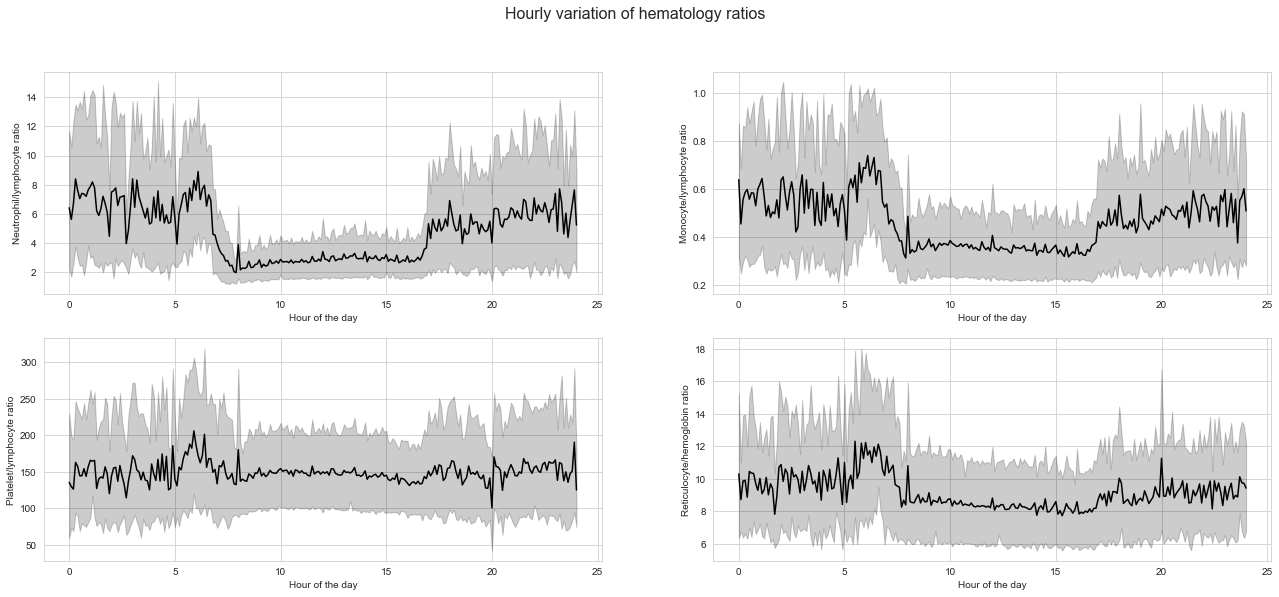

In [24]:
# 'neu:lym'
# 'mon:lym'
#  plt_over_lym
#  retc_over_hb

plot_df = celldyn.sample(250000)
plot_df = plot_df.groupby('draw_hour_dec')['neu:lym'].quantile([0.25, 0.5, 0.75]).to_frame().join(
          plot_df.groupby('draw_hour_dec')['mon:lym'].quantile([0.25, 0.5, 0.75]).to_frame()).join(
          plot_df.groupby('draw_hour_dec').plt_over_lym.quantile([0.25, 0.5, 0.75]).to_frame()).join(
          plot_df.groupby('draw_hour_dec').retc_over_hb.quantile([0.25, 0.5, 0.75]).to_frame()).reset_index()
          
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(22,9))

sns.lineplot(data=plot_df, x='draw_hour_dec', y='neu:lym', color='black', ax=ax[0,0])
sns.lineplot(data=plot_df, x='draw_hour_dec', y='mon:lym', color='black', ax=ax[0,1])
sns.lineplot(data=plot_df, x='draw_hour_dec', y='plt_over_lym', color='black', ax=ax[1,0])
sns.lineplot(data=plot_df, x='draw_hour_dec', y='retc_over_hb', color='black', ax=ax[1,1])


ax[0,0].set_xlabel('Hour of the day')
ax[0,1].set_xlabel('Hour of the day')
ax[1,0].set_xlabel('Hour of the day')
ax[1,1].set_xlabel('Hour of the day')

ax[0,0].set_ylabel('Neutrophil/lymphocyte ratio')
ax[0,1].set_ylabel('Monocyte/lymphocyte ratio')
ax[1,0].set_ylabel('Platelet/lymphocyte ratio')
ax[1,1].set_ylabel('Reticulocyte/hemoglobin ratio')

plt.suptitle('Hourly variation of hematology ratios ', fontsize=16)

In [23]:
meas_cols.extend(['wbc_over_rbc', 'neu_over_seg', 'lym_over_mon', 'wbc_over_plt', 'neu_over_wbc',
                  'plt_over_rbc', 'retc_over_hb', 'rbc_over_irbc', 'plt_over_lym'])

In [33]:
relnum_unique = pd.DataFrame(celldyn.nunique()/celldyn.shape[0])
relnum_unique.columns = ['relnum_unique']

In [48]:
keep_meas_cols = relnum_unique.loc[meas_cols].query('relnum_unique>0.1').sort_values('relnum_unique', ascending=False).index

# Identify exemplars

In [49]:
feature_correlations = []
for i in tqdm(range(20)):
    feature_correlations.append(celldyn.sample(5000)[keep_meas_cols].corr(method='kendall'))

100%|██████████| 20/20 [01:22<00:00,  4.12s/it]


In [50]:
from sklearn.cluster import AffinityPropagation

In [60]:
w = 2
count_dict = defaultdict(int)
for corss in feature_correlations:
    af_clust = AffinityPropagation(random_state=0, affinity='precomputed')
    af_clust.fit(1-np.exp(w*(1-corss)))
    for exemplar in corss.columns[af_clust.cluster_centers_indices_]:
        count_dict[exemplar] += 1/len(feature_correlations)

In [61]:
pd.DataFrame(count_dict, index=[1]).T.rename(columns={1:'count'}).sort_values('count', ascending=False)

,count
c_b_mch,1.00
c_b_bas,1.00
c_b_pmic,1.00
c_b_mon,1.00
c_b_plti,1.00
c_b_neu,1.00
c_b_eos,1.00
c_b_lym,0.95
c_b_hgb_usa,0.95
neu_over_seg,0.90


## Reduce dimensionality

In [62]:
from umap import UMAP
from sklearn.decomposition import PCA, FactorAnalysis, NMF, SparseCoder, SparsePCA
from sklearn.preprocessing import StandardScaler, QuantileTransformer, FunctionTransformer, MinMaxScaler
from sklearn.pipeline import Pipeline

In [63]:
reduced_dimensions = 6
# manhattan: 40s, 50.000 samples
# poincarre: 4m, 50.000 samples
# fractional_distance: 2m, 50.000 samples
dist =  fractional_distance #, poincarre_dist, manhattan, hyperboloid_dist
reducer = UMAP(n_components=reduced_dimensions, n_neighbors=50, n_jobs=8, min_dist=0, metric=dist, densmap=False)
emb_cols = [f'dim_{i}' for i in range(reduced_dimensions)]

sample_index = celldyn.dropna(subset=keep_meas_cols).sample(250000).index
celldyn_embedded = celldyn.loc[sample_index, meta_cols].copy()
reduce_pipe = Pipeline([
    #('Drop nan', FunctionTransformer(lambda x: x.dropna(axis=0, how='any'))),
    ('Scaling Q', QuantileTransformer(n_quantiles=500, output_distribution='normal', random_state=42)),
    ('Embedder', reducer),
])
reduce_pipe.fit(celldyn.loc[sample_index, keep_meas_cols])
celldyn_embedded.loc[:, emb_cols] = reduce_pipe.transform(celldyn.loc[sample_index, keep_meas_cols])
celldyn_embedded = celldyn_embedded.assign(normal_prick=celldyn_embedded.draw_hour==8)

In [64]:
import plotly.express as px

In [66]:
fig = px.scatter_3d(celldyn_embedded.sample(10000), x='dim_0', y='dim_1', z='dim_2',
                    color='age', size_max=7, opacity=0.15)

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

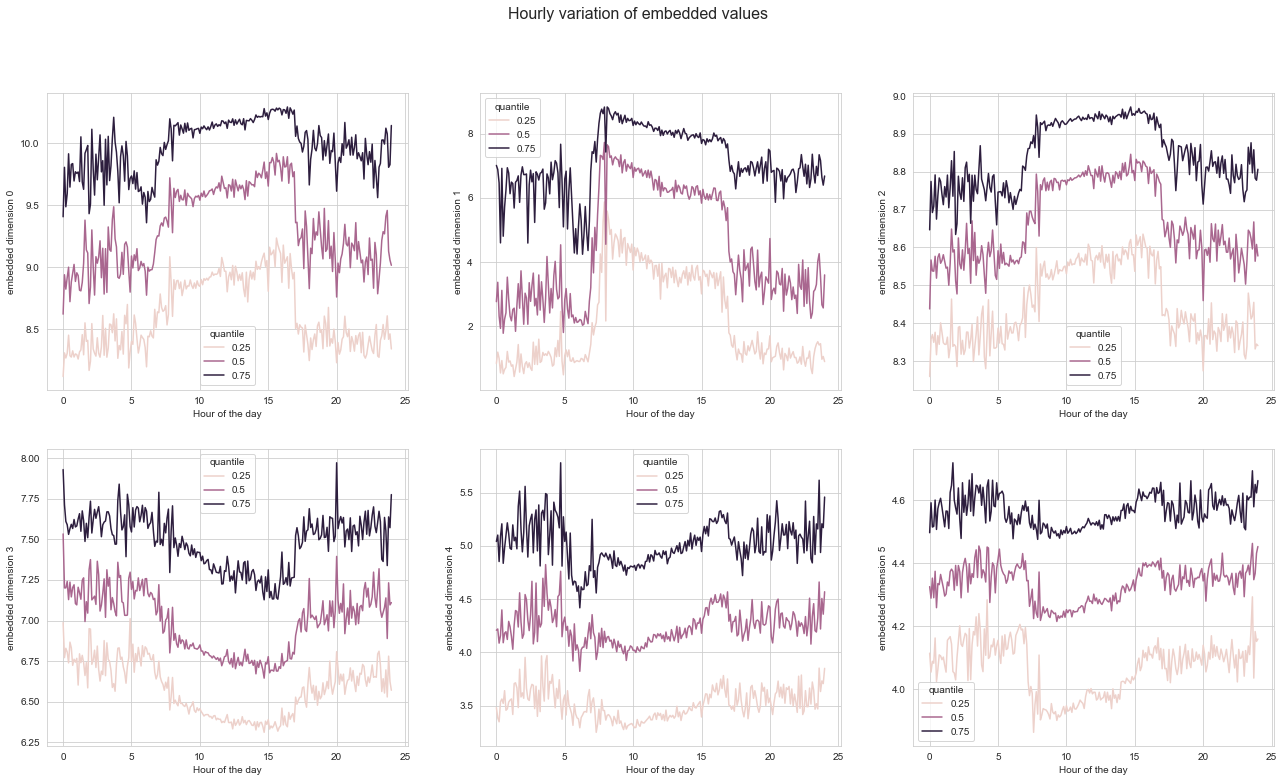

In [86]:
nqs = [0.25, 0.5, 0.75]
reso = 'draw_hour_dec'
aggvar = 'quantile'

plot_df = celldyn_embedded.sample(250000)
plot_df = plot_df.groupby(reso).dim_0.quantile(nqs).to_frame().join(
          plot_df.groupby(reso).dim_1.quantile(nqs).to_frame()).join(
          plot_df.groupby(reso).dim_2.quantile(nqs).to_frame()).join(
          plot_df.groupby(reso).dim_3.quantile(nqs).to_frame()).join(
          plot_df.groupby(reso).dim_4.quantile(nqs).to_frame()).join(
          plot_df.groupby(reso).dim_5.quantile(nqs).to_frame()).reset_index()
plot_df = plot_df.rename(columns={'level_1': 'quantile'})

          
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(22,12))

sns.lineplot(data=plot_df, x=reso, y='dim_0', hue=aggvar, ax=ax[0,0])
sns.lineplot(data=plot_df, x=reso, y='dim_1', hue=aggvar, ax=ax[0,1])
sns.lineplot(data=plot_df, x=reso, y='dim_2', hue=aggvar, ax=ax[0,2])

sns.lineplot(data=plot_df, x=reso, y='dim_3', hue=aggvar, ax=ax[1,0])
sns.lineplot(data=plot_df, x=reso, y='dim_4', hue=aggvar, ax=ax[1,1])
sns.lineplot(data=plot_df, x=reso, y='dim_5', hue=aggvar, ax=ax[1,2])

ax[0,0].set_xlabel('Hour of the day')
ax[0,1].set_xlabel('Hour of the day')
ax[0,2].set_xlabel('Hour of the day')
ax[1,0].set_xlabel('Hour of the day')
ax[1,1].set_xlabel('Hour of the day')
ax[1,2].set_xlabel('Hour of the day')

ax[0,0].set_ylabel('embedded dimension 0')
ax[0,1].set_ylabel('embedded dimension 1')
ax[0,2].set_ylabel('embedded dimension 2')

ax[1,0].set_ylabel('embedded dimension 3')
ax[1,1].set_ylabel('embedded dimension 4')
ax[1,2].set_ylabel('embedded dimension 5')

plt.suptitle('Hourly variation of embedded values ', fontsize=16)
plt.savefig(f'./../artifacts/embedding_intraday_variation.eps', dpi=300, bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

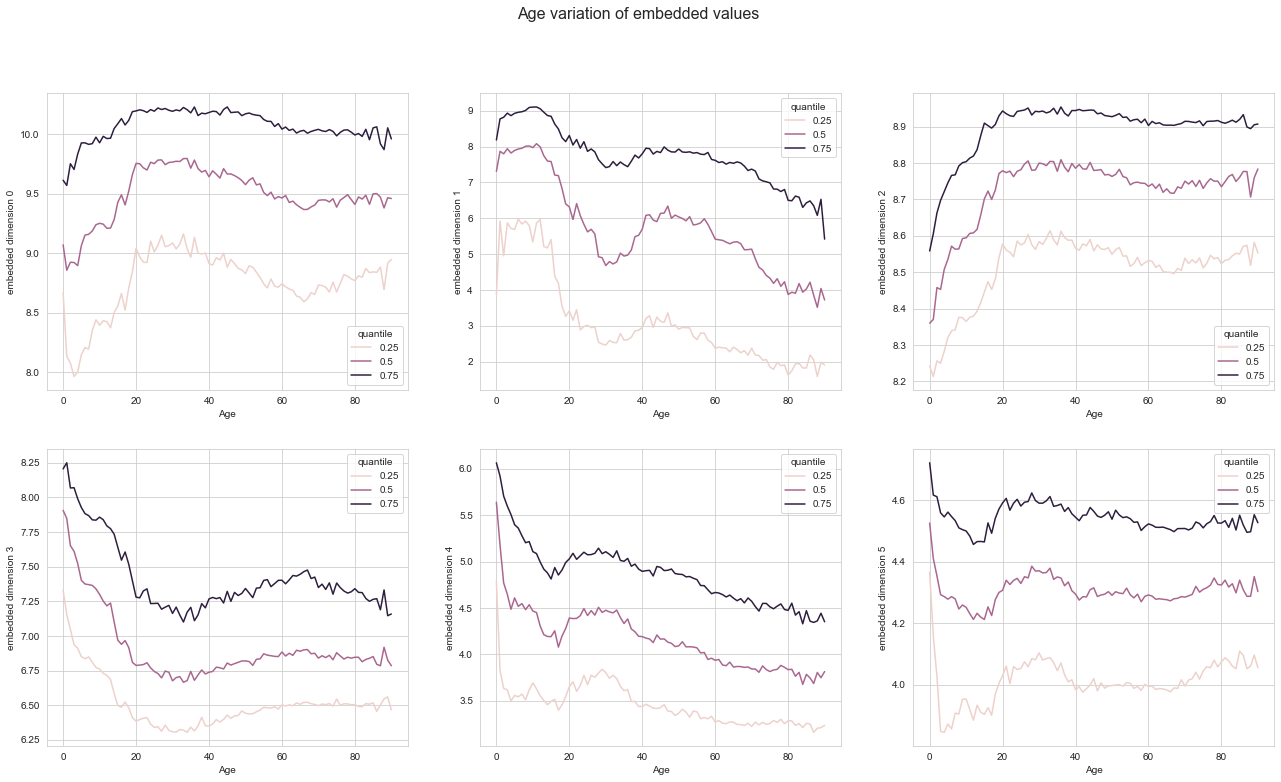

In [84]:
nqs = [0.25, 0.5, 0.75]
reso = 'age'
aggvar = 'quantile'

plot_df = celldyn_embedded.loc[celldyn_embedded.age.between(0,90)]
plot_df = plot_df.groupby(reso).dim_0.quantile(nqs).to_frame().join(
          plot_df.groupby(reso).dim_1.quantile(nqs).to_frame()).join(
          plot_df.groupby(reso).dim_2.quantile(nqs).to_frame()).join(
          plot_df.groupby(reso).dim_3.quantile(nqs).to_frame()).join(
          plot_df.groupby(reso).dim_4.quantile(nqs).to_frame()).join(
          plot_df.groupby(reso).dim_5.quantile(nqs).to_frame()).reset_index()
plot_df = plot_df.rename(columns={'level_1': 'quantile'})

          
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(22,12))

sns.lineplot(data=plot_df, x=reso, y='dim_0', hue=aggvar, ax=ax[0,0])
sns.lineplot(data=plot_df, x=reso, y='dim_1', hue=aggvar, ax=ax[0,1])
sns.lineplot(data=plot_df, x=reso, y='dim_2', hue=aggvar, ax=ax[0,2])

sns.lineplot(data=plot_df, x=reso, y='dim_3', hue=aggvar, ax=ax[1,0])
sns.lineplot(data=plot_df, x=reso, y='dim_4', hue=aggvar, ax=ax[1,1])
sns.lineplot(data=plot_df, x=reso, y='dim_5', hue=aggvar, ax=ax[1,2])

ax[0,0].set_xlabel('Age')
ax[0,1].set_xlabel('Age')
ax[0,2].set_xlabel('Age')
ax[1,0].set_xlabel('Age')
ax[1,1].set_xlabel('Age')
ax[1,2].set_xlabel('Age')

ax[0,0].set_ylabel('embedded dimension 0')
ax[0,1].set_ylabel('embedded dimension 1')
ax[0,2].set_ylabel('embedded dimension 2')

ax[1,0].set_ylabel('embedded dimension 3')
ax[1,1].set_ylabel('embedded dimension 4')
ax[1,2].set_ylabel('embedded dimension 5')

plt.suptitle('Age variation of embedded values ', fontsize=16)
plt.savefig(f'./../artifacts/embedding_intraAge_variation.eps', dpi=300, bbox_inches='tight')

In [88]:
PCA_reducer = PCA()
reduce_pipe = Pipeline([
    #('Drop nan', FunctionTransformer(lambda x: x.dropna(axis=0, how='any'))),
    ('Scaling Q', QuantileTransformer(n_quantiles=500, output_distribution='normal', random_state=42)),
    ('Reduce', PCA_reducer)])
reduce_pipe.fit(celldyn.loc[sample_index, keep_meas_cols])

Pipeline(steps=[('Scaling Q',
                 QuantileTransformer(n_quantiles=500,
                                     output_distribution='normal',
                                     random_state=42)),
                ('Reduce', PCA())])

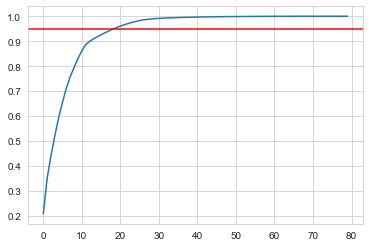

In [89]:
plt.plot(np.cumsum(reduce_pipe.named_steps['Reduce'].explained_variance_ratio_))
plt.axhline(0.95, color='red')

In [91]:
n_comps = 3
PCA_reducer = FactorAnalysis(rotation='varimax', n_components=n_comps)
reduce_pipe = Pipeline([
    #('Drop nan', FunctionTransformer(lambda x: x.dropna(axis=0, how='any'))),
    ('Scaling Q', QuantileTransformer(n_quantiles=500, output_distribution='normal', random_state=42)),
    ('Reduce', PCA_reducer)])
reduce_pipe.fit(celldyn.loc[sample_index, keep_meas_cols])

FA_weights = pd.DataFrame(data=reduce_pipe.named_steps['Reduce'].components_, columns=keep_meas_cols, index=['comp_{}'.format(i) for i in range(n_comps)])

In [92]:
FA_weights

,c_b_mch,c_b_mchc,plt_over_rbc,wbc_over_rbc,wbc_over_plt,plt_over_lym,neu_over_wbc,neu:lym,neu:lyme,neu:mon,...,neu_over_seg,neu:seg,c_b_rbco,c_b_hgb_usa,c_b_hb,c_b_ht,c_b_rbcfcv,c_b_nicv,c_b_nacv,c_b_mcv
comp_0,-0.033610,-0.035162,0.130888,0.000988,-0.116995,-0.067241,-0.179148,-0.172475,-0.176357,-0.109599,...,-0.342874,-0.343180,0.173469,0.163755,0.163958,0.171182,-0.050412,-0.019899,0.024357,-0.018717
comp_1,0.025141,-0.059815,-0.006962,0.113192,0.112525,0.687784,0.832298,0.890637,0.894541,0.490065,...,0.401144,0.401476,-0.249305,-0.245334,-0.245649,-0.234195,0.020791,0.124871,0.009303,0.065179
comp_2,-0.105935,-0.164497,0.311640,0.897962,0.522148,-0.102436,0.460256,0.410779,0.414855,0.425512,...,0.351288,0.351542,0.037015,-0.006015,-0.006030,0.024722,0.008346,0.293711,0.220868,-0.032204


In [95]:
nred = 32
NMF_reducer = NMF(l1_ratio=1, max_iter=2000, n_components=nred)
reduce_pipe = Pipeline([
    #('Drop nan', FunctionTransformer(lambda x: x.dropna(axis=0, how='any'))),
    ('Scaling Q', QuantileTransformer(n_quantiles=500, output_distribution='uniform', random_state=42)),
    ('Reduce', NMF_reducer)])
reduce_pipe.fit(celldyn.loc[sample_index, keep_meas_cols])

NMF_weights = pd.DataFrame(data=reduce_pipe.named_steps['Reduce'].components_, columns=keep_meas_cols, 
                           index=['comp_{}'.format(i) for i in range(nred)])

In [96]:
NMF_reducer.reconstruction_err_

254.829035200845

In [97]:
NMF_weights.sum(axis=0).sort_values(ascending=False)[:25]

c_b_npcv         610.205449
c_b_nicv         475.738096
wbc_over_plt     283.016828
neu:lyme         210.493831
neu:lym          208.796880
neu_over_wbc     203.763343
c_b_pneu         203.080548
rbc_over_irbc    178.645371
c_b_nacv         177.776361
c_b_pseg         174.684849
wbc_over_rbc     156.884174
c_b_pmone        151.694201
c_b_mcv          147.243424
c_b_pmac         144.000376
c_b_pmon         139.832465
c_b_nfcv         138.543463
c_b_mch          135.218533
c_b_neu          128.495649
c_b_pretc        125.989575
c_b_retc         124.279984
neu:nrbc         120.708029
c_b_seg          120.039323
retc_over_hb     116.671283
neu:blst         115.915779
c_b_ht           114.681466
dtype: float64

In [98]:
sPCA_reducer = SparsePCA(method='lars', max_iter=1500)
reduce_pipe = Pipeline([
    #('Drop nan', FunctionTransformer(lambda x: x.dropna(axis=0, how='any'))),
    #('Scaling Q', QuantileTransformer(n_quantiles=100, output_distribution='normal', random_state=123)),
    ('Scaling S', StandardScaler()),
    ('Reduce', sPCA_reducer)])
reduce_pipe.fit(celldyn.loc[sample_index, keep_meas_cols])

sPCA_weights = pd.DataFrame(data=reduce_pipe.named_steps['Reduce'].components_, columns=keep_meas_cols, 
                            index=['comp_{}'.format(i) for i in range(len(keep_meas_cols))])

In [99]:
sPCA_weights.columns[(sPCA_weights!=0).sum(axis=0)>1]

Index(['neu:lyme', 'eos:lyme', 'rbc_over_irbc', 'c_b_plyme', 'c_b_peos',
       'c_b_plti', 'c_b_pneu'],
      dtype='object')

In [100]:
qt =  QuantileTransformer(n_quantiles=50, output_distribution='normal', random_state=123)
sparse_coded_celldyn = SparseCoder(dictionary=qt.fit_transform(celldyn.loc[sample_index, keep_meas_cols].T.values))\
                                                .fit_transform(celldyn.loc[sample_index, keep_meas_cols].T.values)
sCoded_recon = pd.DataFrame(data=sparse_coded_celldyn, columns=keep_meas_cols, 
                            index=['comp_{}'.format(i) for i in range(len(keep_meas_cols))])

d:\VENVS\Envs\hema_embedder\lib\site-packages\sklearn\decomposition\_dict_learning.py:208: RuntimeWarning:

Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.



In [101]:
from scipy.spatial.distance import pdist
from scipy.spatial.distance import cdist
from scipy.spatial import distance
from sklearn.metrics import cohen_kappa_score, matthews_corrcoef
import dcor

In [102]:
# how important is each component in reconstructing the original data
# - sub sample
#   -- determine the distance matrix between the samples on the basis of the original components
#   -- randomly permute the components and retry

def get_distance(X: np.array)-> np.array:
    return pdist(X, metric='cityblock')

def get_rank(D)-> np.array:
    return np.argsort(D)

@lru_cache(maxsize=None)
def permute_vector(l=1000, n=0):
    return np.random.permutation(l)

def get_permuted_rank(X, n_perm=10):
    num_features = X.shape[1]
    num_samples = X.shape[0]

    perm_vectors = [permute_vector(l=num_samples, n=n) for n in range(n_perm)]

    res_array = []    
    for d in range(num_features):
        sub_list = []
        for n in range(n_perm):
            X_perm = X.copy()
            X_perm[:, d] = X[perm_vectors[n], d]
            rank_vector = get_rank(get_distance(X_perm))
            sub_list.append(rank_vector)
        res_array.append(sub_list)
    return res_array

def get_perturbed_rank(X, n_pert=10):
    num_features = X.shape[1]
    num_samples = X.shape[0]

    stats_list = []
    for d in range(num_features):
        stats_list.append((np.mean(X[:, d]), np.std(X[:, d])))

    res_array = []    
    for d in range(num_features):
        sub_list = []
        for n in range(n_pert):
            perburbation_vector = np.random.normal(loc=0, scale=2*stats_list[d][1], size=num_samples)
            X_perb = X.copy()
            X_perb[:, d] = X[:, d] + perburbation_vector
            rank_vector = get_rank(get_distance(X_perb))
            sub_list.append(rank_vector)
        res_array.append(sub_list)
    return res_array

def rank_match(v1,v2):
    return np.sum(v1-v2)/len(v1)

def repeated_agreement_metric(v1, v2, num_rounds=100, num_per_round=100):
    scores = []
    for _ in range(num_rounds):
        batch = np.random.choice(len(v1), size=num_per_round, replace=True)
        score = cohen_kappa_score(v1[batch], v2[batch])
        scores.append(score)
    return np.mean(scores)

def compare_rank_with_original(X, rank_metric='correlation', n_perm=10, n_pert=10, how='permutation'):
    orank = get_rank(get_distance(X))

    if how == 'permutation':
        changed_ranks = get_permuted_rank(X, n_perm=n_perm)
    elif how== 'perturbation':
        changed_ranks = get_perturbed_rank(X, n_pert=n_pert)
    else:
        raise ValueError('how should be either permutation or perturbation')

    # rank-distance
    res = []
    for d in range(X.shape[1]):
        sub_res = []
        for prank in changed_ranks[d]:
            sub_res.append(repeated_agreement_metric(orank.ravel(), prank.ravel()))
        res.append(sub_res)
    return res

def get_permuted_distance_correlation(X, n_perm=10):
    num_features = X.shape[1]
    num_samples = X.shape[0]
    res = []
    for d in tqdm(range(num_features)):
        sub_list = []
        for n in range(n_perm):
            X_perm = X.copy()
            X_perm[:, d] = X[permute_vector(l=num_samples, n=n), d]
            sub_list.append(dcor.distance_correlation(X, X_perm))
        res.append(sub_list)
    return res

def get_perturbed_distance_correlation(X, n_perm=10):
    num_features = X.shape[1]
    num_samples = X.shape[0]
        	
    stats_list = []
    for d in range(num_features):
        stats_list.append((np.mean(X[:, d]), np.std(X[:, d])))

    res = []
    for d in tqdm(range(num_features)):
        sub_list = []
        for n in range(n_perm):
            perburbation_vector = np.random.normal(loc=1, scale=4*stats_list[d][1]/np.abs(stats_list[d][0]), size=num_samples)
            X_perm = X.copy()
            X_perm[:, d] = X[:, d] * perburbation_vector
            dist = dcor.distance_correlation(X, X_perm)
            sub_list.append(dist)
        res.append(sub_list)
    return res


In [103]:
np_perm = 5
np_pert = 5
sample_size = 1000
rank_results = compare_rank_with_original(QuantileTransformer(output_distribution='normal', n_quantiles=100)\
                            .fit_transform(celldyn.dropna().sample(sample_size).loc[:, keep_meas_cols].values), 
                            n_perm=np_perm, n_pert=np_pert, how='perturbation')
rank_results_df = pd.DataFrame(rank_results, index=keep_meas_cols, columns=[f'round_{i}' for i in range(np_perm)])

In [104]:
np_perm = 100
dist_results = get_perturbed_distance_correlation(QuantileTransformer(output_distribution='normal', n_quantiles=100)\
                                                  .fit_transform(celldyn.dropna().sample(sample_size).loc[:, keep_meas_cols].values), n_perm=np_perm)
dist_results_df = pd.DataFrame(dist_results, index=keep_meas_cols, columns=[f'round_{i}' for i in range(np_perm)])

100%|██████████| 80/80 [15:01<00:00, 11.27s/it]


In [105]:
rank_results_df.mean(axis=1).sort_values(ascending=False)[:20]

eos:lym         0.000177
c_b_rbco        0.000177
bas:vlym        0.000177
c_b_wbc         0.000176
c_b_mpv         0.000176
c_b_neu         0.000175
bas:nrbc        0.000158
c_b_pseg        0.000157
c_b_nicv        0.000157
eos:nrbc        0.000157
bas:blst        0.000157
lym_over_mon    0.000155
c_b_hb          0.000137
c_b_lym         0.000137
mon:lyme        0.000137
c_b_lacv        0.000136
c_b_pmone       0.000136
c_b_licv        0.000136
mon:lym         0.000118
c_b_pmic        0.000118
dtype: float64

In [106]:
dist_results_df.mean(axis=1).sort_values(ascending=False)[:20]

blst:lym        0.803097
blst:lyme       0.802457
neu:seg         0.644529
neu_over_seg    0.643484
c_b_phpr        0.458405
bas:lyme        0.371303
bas:lym         0.370435
bas:seg         0.368452
c_b_pbas        0.363856
c_b_bas         0.363620
bas:mon         0.363259
c_b_pmac        0.251944
bas:bnd         0.239323
neu:bnd         0.232473
bas:blst        0.222491
neu:blst        0.218954
neu:nrbc        0.210683
neu:vlym        0.201442
c_b_wbc         0.198734
c_b_neu         0.197650
dtype: float64

# Concrete AutoEncoder

In [ ]:
from concrete_autoencoder import ConcreteAutoencoderFeatureSelector
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, LeakyReLU
from sklearn.model_selection import train_test_split

In [ ]:
X  = QuantileTransformer(output_distribution='normal', n_quantiles=250).fit_transform(celldyn.dropna().sample(100000).loc[:, meas_cols].values)

num_rounds = 100
feature_selection = []
for _ in tqdm(range(num_rounds)):
    x_train, x_test, _, _ = train_test_split(X, X, test_size=0.2, random_state=None)
    x_train = np.reshape(x_train, (len(x_train), -1))
    x_test = np.reshape(x_test, (len(x_test), -1))

    def decoder(x):
        x = Dense(512)(x)
        x = LeakyReLU(0.2)(x)
        x = Dropout(0.1)(x)
        x = Dense(512)(x)
        x = LeakyReLU(0.2)(x)
        x = Dropout(0.1)(x)
        x = Dense(X.shape[1])(x)
        return x

    selector = ConcreteAutoencoderFeatureSelector(K = 32, output_function = decoder, num_epochs = 450)

    selector.fit(x_train, x_train, x_test, x_test)
    feature_selection.append(np.array(meas_cols)[selector.get_support(indices=True)])

In [ ]:
count_dict = defaultdict(int)

for i in feature_selection:
    for j in i:
        count_dict[j] += 1/len(feature_selection)
        
    presence_df = pd.DataFrame(count_dict, index=[0]).T.sort_values(by=0, ascending=False).rename(columns={0:'presence'})

In [158]:
presence_df[:20]

,presence
c_b_phpr,1.00
c_b_mchc,0.98
c_b_pig,0.97
c_b_limn,0.96
c_b_plto,0.96
c_b_pdw,0.94
c_b_irf,0.90
c_b_pmac,0.86
c_b_rbcfmn,0.84
c_b_pimn,0.82


In [ ]:
# https://github.com/bwohlberg/sporco